In [161]:
import numpy as np
import pandas as pd
from ast import literal_eval
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from omegaconf import OmegaConf
from src.similarity import rcmcs_similarity_matrix
import matplotlib.pyplot as plt

In [142]:
arr = np.array([1, 2, 3, 4, 5])
rc = ((1,2,3),)

df = pd.DataFrame([[list(arr), rc]], columns=['A', 'B'])
df.head()

,A,B
0,"[1, 2, 3, 4, 5]","((1, 2, 3),)"


In [143]:
df.loc[0, 'A']

[1, 2, 3, 4, 5]

In [144]:
df.to_csv('test.csv', index=False)

In [145]:
ldf = pd.read_csv('test.csv')
ldf.head()

,A,B
0,"[1, 2, 3, 4, 5]","((1, 2, 3),)"


In [146]:
ldf.loc[0, 'A']

'[1, 2, 3, 4, 5]'

In [147]:
ldf.loc[0, 'B']

'((1, 2, 3),)'

In [148]:
ldf['A']

0    [1, 2, 3, 4, 5]
Name: A, dtype: object

In [149]:
ldf['A'] = ldf['A'].apply(lambda x : np.array(literal_eval(x)))
ldf['B'] = ldf['B'].apply(literal_eval)

In [150]:

ldf.loc[0, 'A'], type(ldf.loc[0, 'A'])

(array([1, 2, 3, 4, 5]), numpy.ndarray)

In [151]:
ldf.loc[0, 'B'], type(ldf.loc[0, 'B'])

(((1, 2, 3),), tuple)

In [152]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')
reactions = load_json(Path(filepaths.data) / 'sprhea' / ('v3_folded_test' + ".json"))
rules = pd.read_csv(
            filepath_or_buffer=Path(filepaths.artifacts) / 'minimal1224_all_uniprot.tsv',
            sep='\t'
        )
rules.set_index('Name', inplace=True)
adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / ('v3_folded_test' + ".csv")
    )
reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

Constructing v3_folded_test sparse adjacency matrix


In [153]:
len(reactions), len(idx_feature), adj.nonzero()[0].shape

(164, 164, (193,))

In [154]:
with open('test_embeddings.txt', 'w') as f:
    for pid in idx_sample.values():
        f.write(str(pid) + '\n')

In [155]:
data_dir = '/home/stef/quest_data/hiec/scratch/sprhea_v3_folded_test/rcmcs/3fold'

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(data_dir + '/train_val_' + str(i) + '.parquet')
    )
test = pd.read_parquet(data_dir + '/test.parquet')

In [156]:
train_val[0].head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,1,4,P58466,337,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",O.*NC(C(*)=O)C(C)OP(=O)(O)O>>*NC(C(*)=O)C(C)O....,"[[[0], [8, 9]], [[8], [2, 1]]]",1
1,1,5,P58466,245,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",O.*NC(COP(=O)(O)O)C(*)=O>>*NC(CO)C(*)=O.O=P(O)...,"[[[0], [4, 5]], [[4], [2, 1]]]",1
2,13,22,Q09131,1068,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",*O.O=P(O)(O)O>>O.*OP(=O)(O)O,"[[[1], [2, 1]], [[0], [1, 2]]]",1
3,93,4,O02658,337,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",O.*NC(C(*)=O)C(C)OP(=O)(O)O>>*NC(C(*)=O)C(C)O....,"[[[0], [8, 9]], [[8], [2, 1]]]",1
4,93,5,O02658,245,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",O.*NC(COP(=O)(O)O)C(*)=O>>*NC(CO)C(*)=O.O=P(O)...,"[[[0], [4, 5]], [[4], [2, 1]]]",1


In [157]:
print([len(elt) for elt in train_val])
print(len(test))

[862, 382, 470]
48


In [158]:
S = rcmcs_similarity_matrix(
    reactions,
    rules,
    idx_feature
)

Preparing reaction pairs

Rxn # 162 : 50789
Processing pairs



100%|██████████| 689/689 [00:12<00:00, 56.19it/s]  


Number of similarities below 0.8: 1.0
Number of similarities below 0.6: 0.7180974477958236
Number of similarities below 0.4: 0.5626450116009281


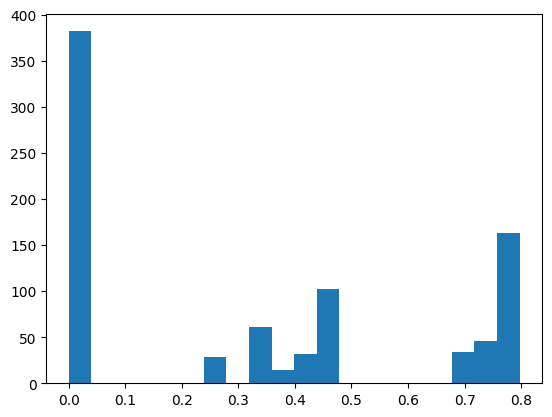

Number of similarities below 0.8: 1.0
Number of similarities below 0.6: 0.8979057591623036
Number of similarities below 0.4: 0.743455497382199


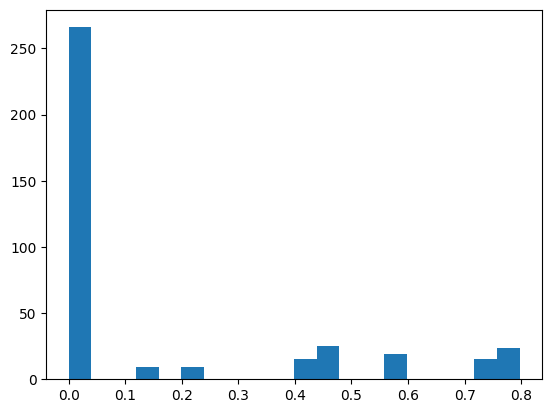

Number of similarities below 0.8: 1.0
Number of similarities below 0.6: 0.7829787234042553
Number of similarities below 0.4: 0.4851063829787234


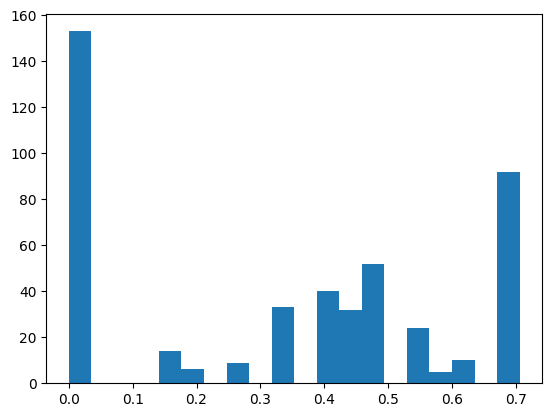

Number of similarities below 0.8: 1.0
Number of similarities below 0.6: 0.7916666666666666
Number of similarities below 0.4: 0.75


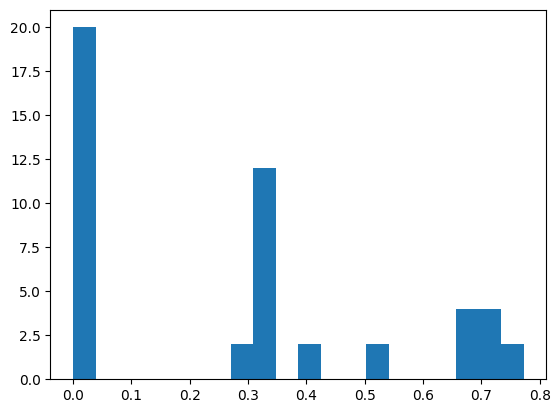

In [171]:
thresholds = [0.8, 0.6, 0.4]
for i, val in enumerate(train_val):
    val_ridx = val['reaction_idx'].values
    train = pd.concat([train_val[j] for j in range(3) if j != i])
    train_ridx = train['reaction_idx'].values
    max_sims = S[train_ridx][:, val_ridx].max(axis=0)
    for th in thresholds:
        print(f"Number of similarities below {th}: {np.sum(max_sims <= th) / len(max_sims)}")
    plt.hist(max_sims, bins=20)
    plt.show()

val_ridx = test['reaction_idx'].values
train = pd.concat(train_val)
train_ridx = train['reaction_idx'].values
max_sims = S[train_ridx][:, val_ridx].max(axis=0)
for th in thresholds:
    print(f"Number of similarities below {th}: {np.sum(max_sims <= th) / len(max_sims)}")
plt.hist(max_sims, bins=20)
plt.show()